# 2D variability analysis for HBEC IFN experiment

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
import itertools
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.7.egg')
sys.path.append('/data/home/Github/misc-seq/miscseq/')
import encode
import memento

In [3]:
data_path = '/data_volume/ifn_hbec/'

### Get the TFs

In [4]:
tf_df = pd.read_csv('DatabaseExtract_v_1.01.csv', index_col=0)
tf_df = tf_df[tf_df['TF assessment'] == 'Known motif']
tfs = tf_df['HGNC symbol'].tolist()

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [5]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts.h5ad')

In [6]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

In [7]:
adata.shape

(69252, 36588)

### Setup memento

In [8]:
adata.obs['q'] = 0.25*0.2

In [9]:
memento.setup_memento(adata, q_column='q')

### Run memento for STAT1

In [10]:
tf = 'STAT1'
ct = ['ciliated']
stim = 'beta'

def get_2d_moments(tf, ct, stim):
    
    adata_stim = adata.copy()[
        adata.obs.cell_type.isin(ct) & \
        adata.obs.stim.isin(['control', stim])].copy()
    # time_converter={0:0, int(tp):1}
    # adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

    memento.create_groups(adata_stim, label_columns=['time', 'donor'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.9)
    moment_1d_df = memento.get_1d_moments(adata_stim, groupby='time')

    memento.compute_2d_moments(adata_stim, list(itertools.product([tf], adata_stim.var.index)))

    moment_df = memento.get_2d_moments(adata_stim, groupby='time')
    
    return moment_df


In [14]:
beta_df = get_2d_moments('STAT1', ['ciliated'], 'beta')
alpha_df = get_2d_moments('STAT1', ['ciliated'], 'alpha')
gamma_df = get_2d_moments('STAT1', ['ciliated'], 'gamma')
lambda_df = get_2d_moments('STAT1', ['ciliated'], 'lambda')

beta_df['stim'] = 'beta'
alpha_df['stim'] = 'alpha'
df = pd.concat([alpha_df, beta_df])

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


(-0.75, 1)

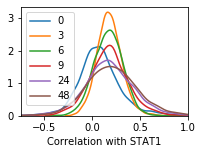

In [20]:
plt.figure(figsize=(3, 2))
for tp in ['0', '3', '6', '9', '24', '48']:#['0', '3', '6', '9', '24', '48']:
    sns.distplot(lambda_df['time_' + tp], hist=False, label=tp)
# plt.legend(, frameon=False)
plt.xlabel('Correlation with STAT1')
plt.xlim(-0.75, 1)

In [ ]:
tf = 'STAT1'
for ct in cts:
    for tp in tps:
        for stim in stims:
                            
            print('starting', ct, tp, stim)

            adata_stim = adata.copy()[
                adata.obs.cell_type.isin(ct) & \
                adata.obs.stim.isin(['control', stim]) & \
                adata.obs.time.isin(['0',tp]), :].copy()
            time_converter={0:0, int(tp):1}
            adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

            memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
            memento.compute_1d_moments(adata_stim, min_perc_group=.9)
            memento.compute_2d_moments(adata_stim, list(itertools.product([tf], adata_stim.var.index)))

            moment_df = memento.get_2d_moments(adata_stim, groupby='time_step')
            moment_df.to_csv('/data_volume/ifn_hbec/coex_test/moments_{}_{}_{}_{}.csv'.format('-'.join(ct), stim, tp, tf), index=False)
            gene_list = moment_df[(moment_df['time_step_0'] > 0.35) | (moment_df['time_step_1'] > 0.35)].gene_2.tolist()

            if len(gene_list) < 10:
                continue

            memento.compute_2d_moments(adata_stim, list(itertools.product([tf], gene_list)))

            memento.ht_2d_moments(
                adata_stim, 
                formula_like='1 + time_step',
                cov_column='time_step', 
                num_boot=10000, 
                verbose=1,
                num_cpus=13)

            if 'mv_regressor' in adata_stim.uns['memento']:
                del adata_stim.uns['memento']['mv_regressor']
            adata_stim.write('/data_volume/ifn_hbec/tf_test/{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf))

### Run memento for each subset, comparing to control

In [35]:
cts = [['ciliated'], ['bc', 'club'], ['basal']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [36]:
condensed_tfs = []
for tf in tfs:
    if 'STAT' in tf:
        condensed_tfs.append(tf)
    elif 'IRF' in tf:
        condensed_tfs.append(tf)
    elif 'NFKB' in tf:
        condensed_tfs.append(tf)
    elif 'JUN' in tf:
        condensed_tfs.append(tf)
    elif 'MYC' in tf:
        condensed_tfs.append(tf)
    elif 'FOS' in tf:
        condensed_tfs.append(tf)
    else:
        continue

In [ ]:
for ct in cts:
    for tp in tps:
        for stim in stims:
                            
            print('starting', ct, tp, stim)

            adata_stim = adata.copy()[
                adata.obs.cell_type.isin(ct) & \
                adata.obs.stim.isin(['control', stim]) & \
                adata.obs.time.isin(['0',tp]), :].copy()
            time_converter={0:0, int(tp):1}
            adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

            memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
            memento.compute_1d_moments(adata_stim, min_perc_group=.9)

            relevant_tfs = list(set(condensed_tfs) & set(adata_stim.var.index))
            
            for tf in relevant_tfs:
                memento.compute_2d_moments(adata_stim, list(itertools.product([tf], adata_stim.var.index)))
                
                moment_df = memento.get_2d_moments(adata_stim, groupby='time_step')
                moment_df.to_csv('/data_volume/ifn_hbec/coex_test/moments_{}_{}_{}_{}.csv'.format('-'.join(ct), stim, tp, tf), index=False)
                gene_list = moment_df[(moment_df['time_step_0'] > 0.35) | (moment_df['time_step_1'] > 0.35)].gene_2.tolist()
                
                if len(gene_list) < 10:
                    continue
                    
                memento.compute_2d_moments(adata_stim, list(itertools.product([tf], gene_list)))

                memento.ht_2d_moments(
                    adata_stim, 
                    formula_like='1 + time_step',
                    cov_column='time_step', 
                    num_boot=10000, 
                    verbose=1,
                    num_cpus=13)

                if 'mv_regressor' in adata_stim.uns['memento']:
                    del adata_stim.uns['memento']['mv_regressor']
                adata_stim.write('/data_volume/ifn_hbec/coex_test/{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf))